Marcin Wardyński
wtorek, 9:45

## Lab 3

### 5. Gaussowski Naiwny Klasyfikator Bayesa

##### 1. i 2. Zaimplementuj Naiwny Klasyfikator Bayesa

Dla zachowania stabilności numerycznej, w niektórych miejsca musiał zostać dodana mała wartość: 1e-9, żeby ustrzec się przed dzieleniem przez zero oraz logarytmowaniem zera.

In [2]:
import numpy as np

class GaussianNaiveBayes:
    
    def __init__(self, epsilon=1e-9):
        self.epsilon = epsilon
        self.mean = None
        self.std = None
        self.probs = None
    
    def fit(self, X, y):
        self.classes, counts = np.unique(y, return_counts=True)
        self.probs = counts / len(y)
        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.std = np.zeros((len(self.classes), X.shape[1]))

        for idx, label in enumerate(self.classes):
            relevant_samples = X[y == label]
            self.mean[idx] = np.mean(relevant_samples, axis=0)
            self.std[idx] = np.std(relevant_samples, axis=0) + self.epsilon

    def predict(self, X):
        labels = []
        
        for x in X:
            likelihoods = np.zeros(len(self.classes))

            for k in range(len(self.classes)):
                pdf_values = self.gaussian_pdf(x, self.mean[k], self.std[k])
                log_likelihood = np.sum(np.log(pdf_values + self.epsilon))
                likelihoods[k] = log_likelihood

            class_probs = np.log(self.probs) + likelihoods
            labels.append(np.argmax(class_probs))

        return np.array(labels)
    
    def gaussian_pdf(self, x, mean, std):
        coeff = 1 / np.sqrt(2 * np.pi * std**2)
        exp = np.exp(-((x - mean)**2) / (2 * std**2))
        return coeff * exp


##### 3. Przetestuj działanie implementacji i porównaj z scikit-learn GaussianNB

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import time

def repeatExperiment(n_times, X, y, test_size, classifier):
    
    start_time = time.time()

    accuracy_collection = []
    precision_collection = []
    f1_score_collection = []

    for _ in range(n_times):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision, _, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

        accuracy_collection.append(accuracy)
        precision_collection.append(precision)
        f1_score_collection.append(f1_score)

    accuracy_avg = np.mean(accuracy_collection)
    precision_avg = np.mean(precision_collection)
    f1_score_avg = np.mean(f1_score_collection)

    finish_time = time.time() - start_time

    return accuracy_avg, precision_avg, f1_score_avg, finish_time
        


In [4]:
from sklearn.datasets import load_iris

from sklearn.naive_bayes import GaussianNB
import pandas as pd

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X, y, 0.4, GaussianNaiveBayes())
print(f'avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')

accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X, y, 0.4, GaussianNB())
print(f'avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')


avg-values -> accuracy: 0.9549999999999998, precision: 0.9563390285374138, f1 score: 0.9549499197774022; experiment done in: 0.053385019302368164s
avg-values -> accuracy: 0.9608333333333332, precision: 0.9624458621838619, f1 score: 0.9606883435503987; experiment done in: 0.018861770629882812s


Moja implementacja Naiwnego Klasyfikatora Bayesa w oparciu o rozkład Gaussa nie ustępuje implementacji `GaussianNB` ze `scikit learn`, a że jest zaimplementowana w dość prosty sposób, to jej czas wykonania jest ok 2x wolniejszy.

##### 5.4. Przetestuj klasyfikator dla zbioru Breast Cancer

In [5]:
class GaussianNaiveBayesNew:
    
    def __init__(self):
        self.mean = None
        self.std = None
        self.probs = None
    
    def fit(self, X, y):
        self.classes, counts = np.unique(y, return_counts=True)
        self.probs = counts / len(y)
        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.std = np.zeros((len(self.classes), X.shape[1]))

        for idx, label in enumerate(self.classes):
            relevant_samples = X[y == label]
            self.mean[idx] = np.mean(relevant_samples, axis=0)
            self.std[idx] = np.std(relevant_samples, axis=0)

    

In [6]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X, y, 0.3, GaussianNaiveBayes())
print(f'avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')

accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X, y, 0.3, GaussianNB())
print(f'avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')

avg-values -> accuracy: 0.9365497076023391, precision: 0.9375003128201735, f1 score: 0.9364411800422279; experiment done in: 0.07160401344299316s
avg-values -> accuracy: 0.9342105263157894, precision: 0.9347114250193996, f1 score: 0.933866161263602; experiment done in: 0.019856929779052734s


Skoro obydwa klasyfikator, zaimplementowany przeze mnie `GaussianNaiveBayes` oraz `GaussianNB` ze `sklearn`, dostarczają podobnej jakości wyników, w dalszej części tego ćwiczenia będę używał swojej implementacji. 

##### Ze skalowaniem (StandardScaler)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_breast_scaled = scaler.fit_transform(X)

accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X_breast_scaled, y, 0.3, GaussianNaiveBayes())
print(f'avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')



avg-values -> accuracy: 0.9292397660818713, precision: 0.9298370498090301, f1 score: 0.929124729953922; experiment done in: 0.07257390022277832s


Widzimy, że przeskalowanie danych `StandardScaler` obniżyło nieznacznie jakość klasyfikacji

##### Z użyciem PCA i Kernel PCA

PCA i kPCA użyjemy na już przeskalowanych danych, żeby żaden z komponentów nie zdominował metody tylko dlatego, że jest inaczej wyskalowany.

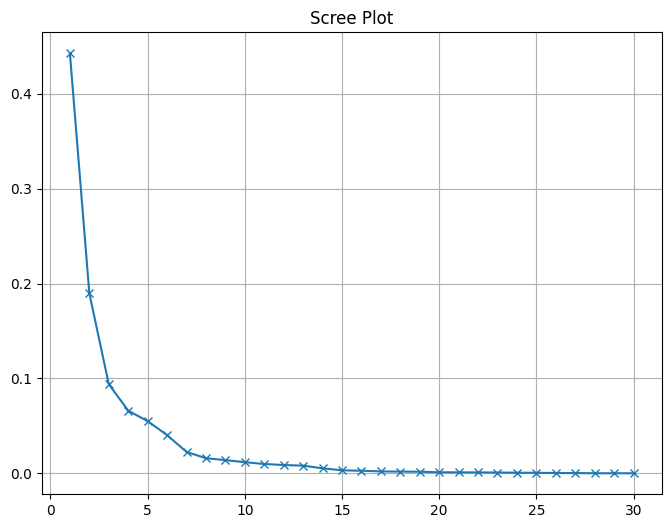

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X_breast_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='x', linestyle='-')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

Dla PCA optymalną liczbą komponentów wydaje się być 7, ale krzywa zauważalnie opada aż do 15.

In [9]:
n_components_range = range(7, 16)

for n_components in n_components_range:
    pca = PCA(n_components=n_components)
    X_breast_scaled_pca = pca.fit_transform(X_breast_scaled)

    accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X_breast_scaled_pca, y, 0.3, GaussianNaiveBayes())
    print(f'{n_components}: avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')  


7: avg-values -> accuracy: 0.9230994152046785, precision: 0.9243689467192313, f1 score: 0.9223994568243981; experiment done in: 0.07120513916015625s
8: avg-values -> accuracy: 0.9169590643274855, precision: 0.9180597624185826, f1 score: 0.916412568759208; experiment done in: 0.06944704055786133s
9: avg-values -> accuracy: 0.9192982456140353, precision: 0.9195328768604583, f1 score: 0.9186775180516713; experiment done in: 0.0691680908203125s
10: avg-values -> accuracy: 0.9178362573099415, precision: 0.9189093018149036, f1 score: 0.9174667925430218; experiment done in: 0.07027888298034668s
11: avg-values -> accuracy: 0.9102339181286551, precision: 0.9107192206906035, f1 score: 0.9099082221134177; experiment done in: 0.06948494911193848s
12: avg-values -> accuracy: 0.9128654970760233, precision: 0.9145238988505271, f1 score: 0.9120609374509175; experiment done in: 0.06672811508178711s
13: avg-values -> accuracy: 0.923391812865497, precision: 0.9244322314197845, f1 score: 0.922924098192923

Możemy zaobserwować brak zauważalnej poprawy dla liczby komponentów większej niż 7, więc faktycznie 7 komponentów jest optymalną ilością dla tej PCA.

Natomiast wyniki klasyfikacji po zastosowaniu PCA nie polepszyły się lecz wręcz pogorszyły. Wartości, accuracy, precision i f1-score spadły o ok 0.5-1pp.

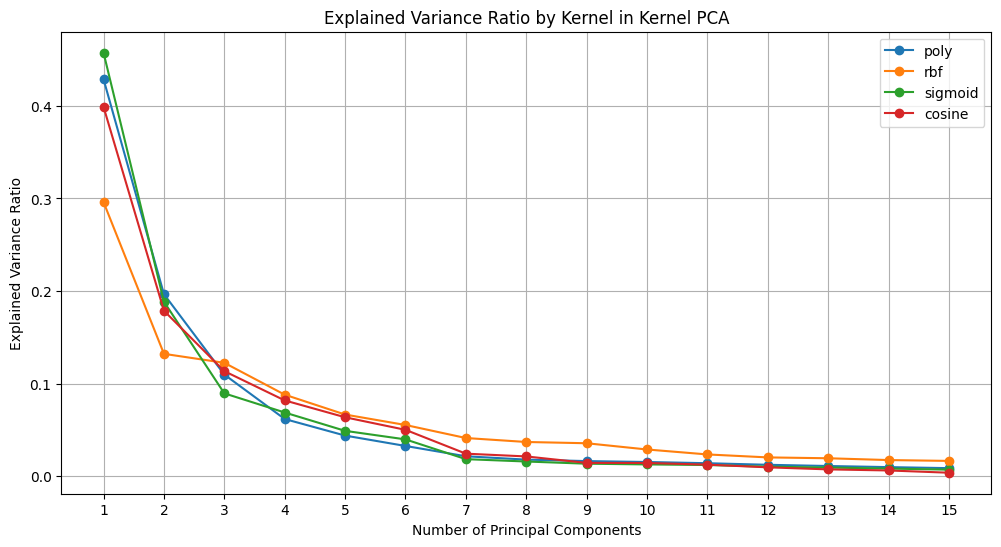

In [10]:
from sklearn.decomposition import KernelPCA

kernels = ['poly', 'rbf', 'sigmoid', 'cosine']
n_components = range(1, 16)  
explained_variance_ratios = {kernel: [] for kernel in kernels}

for kernel in kernels:
    kpca = KernelPCA(kernel=kernel, n_components=max(n_components))
    kpca.fit(X_breast_scaled)

    total_variance = np.sum(kpca.eigenvalues_)
    explained_variance_ratios[kernel] = kpca.eigenvalues_[:len(n_components)] / total_variance 

plt.figure(figsize=(12, 6))
for kernel in kernels:
    plt.plot(n_components, explained_variance_ratios[kernel], marker='o', label=kernel)

plt.title('Explained Variance Ratio by Kernel in Kernel PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(n_components)
plt.legend()
plt.grid(True)
plt.show()

Jak widzimy, duże wypłaszczenie zachodzi dla więcej niż siedmiu komponentów, więć dla każdej rozważanej kPCA ograniczę się właśnie do siedmiu komponentów.

In [11]:
for kernel in kernels:
    kpca = KernelPCA(kernel=kernel, n_components=7)
    X_breast_scaled_kpca = kpca.fit_transform(X_breast_scaled)

    accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X_breast_scaled_kpca, y, 0.3, GaussianNaiveBayes())
    print(f'GaussianNaiveBayes: {kernel}: avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')  


GaussianNaiveBayes: poly: avg-values -> accuracy: 0.8935672514619883, precision: 0.8994891193657061, f1 score: 0.8903580845110671; experiment done in: 0.06655406951904297s
GaussianNaiveBayes: rbf: avg-values -> accuracy: 0.921345029239766, precision: 0.9217230448213873, f1 score: 0.9210451078064634; experiment done in: 0.06708312034606934s
GaussianNaiveBayes: sigmoid: avg-values -> accuracy: 0.9307017543859649, precision: 0.9310010438523977, f1 score: 0.9303628874967551; experiment done in: 0.0660848617553711s
GaussianNaiveBayes: cosine: avg-values -> accuracy: 0.9409356725146196, precision: 0.9413240488255962, f1 score: 0.9407922497862649; experiment done in: 0.06612706184387207s


Trzy wypróbowanych kerneli dla kPCA: poly, rbf, sigmoid, jedynia pogorszyły jakość klasyfikacji, co można zobaczyć na wynikach powayżej. Natomiast kernel cosine podniół wartości określające jakość klasyfikacji o ok 0.5pp.

In [12]:
from sklearn.preprocessing import PowerTransformer

smallest_value = np.min(X)
shift_value = smallest_value + 1e-5

X_shifted = X + 1e-5

power_transformer = PowerTransformer(method='box-cox')
power_transformer.fit(X_shifted)

X_boxcox = power_transformer.transform(X_shifted)

accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X_boxcox, y, 0.3, GaussianNaiveBayes())
print(f'avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')   


avg-values -> accuracy: 0.9488304093567249, precision: 0.9491823476274499, f1 score: 0.9487998640680099; experiment done in: 0.0685429573059082s


Przy transformacji box-cox zastosowałem `PowerTransformer` z modułu `sklearn.preprocessing`. Po tej transformacji wariancja danych została ustabilizowana dają dane w lepszym stopniu odwzorowujące rozkład normaly. Nasz klasyfikator również bazuje na rozkładzie normalnym, stąd wyniki klasyfikacji uległy poprawie dla accuracy, precision i f1-score o ok 1.5pp względem danych nieprzygotowanych.

In [13]:
from sklearn.ensemble import RandomForestClassifier

accuracy_avg, precision_avg, f1_score_avg, ex_time = repeatExperiment(20, X, y, 0.3, RandomForestClassifier())
print(f'avg-values -> accuracy: {accuracy_avg}, precision: {precision_avg}, f1 score: {f1_score_avg}; experiment done in: {ex_time}s')

avg-values -> accuracy: 0.9608187134502921, precision: 0.9613705021300794, f1 score: 0.960764312295009; experiment done in: 1.615574598312378s


Powyższy kod pokazuje, że las losowy jest bardzo mocnym klasyfikatorem, gdyż bez żadnego wstępnego przygotowywania danych uzyskał wynik lepszy o ok. 1pp. od wcześniejszego najlepszego wyniku klasyfikacji Naiwnym Klasyfikatorem Bayesa po zastosowaniu transformacji box-cox.

### 6. Naiwny Klasyfikator Bayesa z rozkładem Bernoulliego

In [14]:
import numpy as np

class BernoulliNaiveBayes:
    
    def __init__(self):
        self.probs = None
        self.feats = None
    
    def fit(self, X, y):
        values, counts = np.unique(y, return_counts=True)
        self.probs = counts / len(y)
        self.feats = np.zeros((len(self.probs), X.shape[1]))

        for i, k in enumerate(values):
            indices = np.where(y == k)
            relevant_samples = X[indices]
            
            sum = (np.sum(relevant_samples, axis=0) + 1) # +1 for Laplace smoothing
            self.feats[i, :] = sum / (relevant_samples.shape[0] + 2) # +2 for Laplace smoothing
        
        return self
    
    def predict(self, X, calc_logs=True):
        labels = []

        # X = X.toarray().flatten()
        for x_sparse in X:
            x = x_sparse.toarray().flatten()
            selected_k = -1
            max_prob_for_k = -np.inf

            for k in range(len(self.probs)):

                prob_k = self.calculate_prob_logs(k, x) if calc_logs else self.calculate_prob_directly(k, x)

                if prob_k > max_prob_for_k:
                    max_prob_for_k = prob_k
                    selected_k = k

            labels.append(selected_k)

        return labels
    
    def calculate_prob_directly(self, k, x):
        prob_xi_ck = self.feats[k] ** x * (1 - self.feats[k]) ** (1 - x)
        prob_k = self.probs[k] * np.prod(prob_xi_ck)
        return prob_k
    
    def calculate_prob_logs(self, k, x):
        epsilon = 1e-10  # Small constant to avoid log(0)
        
        log_prob_xi_ck = x * np.log(self.feats[k] + epsilon) + (1 - x) * np.log(1 - self.feats[k] + epsilon)
        log_prob_k = np.log(self.probs[k] + epsilon) + np.sum(log_prob_xi_ck)

        return log_prob_k



Przygotowanie zestawu danych "20 news group"
- stworzenie bag of words
- sprowadzenie ilości wystąpień do informacji wys†ępuje lub nie: 0 lub 1.

In [15]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

X_data = newsgroups.data
y = newsgroups.target

cnt_vect = CountVectorizer()
cnt_vect.fit(X_data)
X = cnt_vect.transform(X_data)
X.data[X.data>1] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

start_time = time.time()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
finish_time = time.time() - start_time

accuracy = accuracy_score(y_test, y_pred)
precision, _, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}, precision: {precision}, f1 score: {f1_score} in {finish_time}s')

accuracy: 0.4586206896551724, precision: 0.6972389346200848, f1 score: 0.4627476819885381 in 0.09296894073486328s


In [17]:
bnb = BernoulliNaiveBayes()

start_time = time.time()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test, calc_logs=False)
finish_time = time.time() - start_time

accuracy = accuracy_score(y_test, y_pred)
precision, _, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}, precision: {precision}, f1 score: {f1_score} in {finish_time}s')

accuracy: 0.3647214854111406, precision: 0.6259026365554283, f1 score: 0.3769738885564819 in 144.70827198028564s


/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
start_time = time.time()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test, calc_logs=True)
finish_time = time.time() - start_time

accuracy = accuracy_score(y_test, y_pred)
precision, _, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}, precision: {precision}, f1 score: {f1_score} in {finish_time}s')

accuracy: 0.4586206896551724, precision: 0.6972389346200848, f1 score: 0.4627476819885381 in 97.22804689407349s


Powyżej widzimy trzy wyniki dla klasyfikacji tekstów ze zbioru "20 news groups".  
Pierwsze odczyty accuracy, precision i f1-score są dla implementacji `BernoulliNB` z `sklearn`. Wyniki są dość kiepskiej jakości, gdyż accuracy i f1-score wynoszą odpowiednio 0.48 i 0.46, precision ma niewiele większą wartość: 0.66. Jak widzimy rozpatrując poprawne dopasowania dokumentów do klas otrzymujemy dość kiepski wynik accuracy 0.48, natomiast uśredniając precision dla klasyfikacji każdej klasy z osobna, otrzymujemy lepszy lecz wciąż niezadawalający wynik 0.66.

Przy implementacji własnego Naiwnego Klasyfikatora Bayesa z rozkładem Bernoulliego obliczającego prawdopodobieństwa klas poprzez wymnażanie wprost składowych pradopodobieństwa warunkowego, otrzymujemy jeszcze gorsze wyniki, gdyż nawet przy zastosowaniu wygładzania Laplace'a, wymnażamy dużą ilość bardzo małych liczb, przez co algorytm nie jest numerycznie precyzyny. Wyniki to accuracy: 0.3925729442970822, precision: 0.5602798764360041, f1-score: 0.38651453024352067.

Ostatnia grupa wyników dorównuje jakością klasyfikatorowi `BernoulliNB` z `sklearn`,  a to dzięki zastosowaniu operacji logarytmowania przy obliczaniu prawdopodobieństw warunkowych, co z kolei zamieniło iloczyny na sumy i znacznie poprawiło precyzję obliczeń. Niestety, jakość klasyfikacji, tak jak i przy implementacji z `sklearn`, nie wypada dobrze. Wygląda na to, że NKB z rozkładem Bernoulliego nie spełnia dobrze swojej roli przy zadanym zbiorze danych.

Dodatkowo warto zwrócić uwagę, że implementacja ze `sklearn` potrzebowała na klasyfikację 0.1s, podczas gdy moje implementacje odpowiednio 138s i 107s.



In [19]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

start_time = time.time()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
finish_time = time.time() - start_time

accuracy = accuracy_score(y_test, y_pred)
precision, _, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'accuracy: {accuracy}, precision: {precision}, f1 score: {f1_score} in {finish_time}s')

accuracy: 0.6541114058355437, precision: 0.6637891267067302, f1 score: 0.6467255308767145 in 72.18647193908691s


Na zakończenie, zastosowałem do zbioru danych "20 news groups" las losowy jako klasyfikator-benchmark. Działał on długo i poprawił accuracy do 0.61 oraz f1-score do 0.64, precyzja pozostała na poziomie ok 0.66. Najwyraźnie otrzymanie lepszych wyników klasyfikacji tego zbioru danych nie jest zadaniem prostym.

### 7. Naiwny Klasyfikator Bayesa dla zbioru danych Adult Income

W pierwszej kolejności pobiorę i przygotuję dane:

In [160]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.feature_selection import SequentialFeatureSelector


feature_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status", "Occupation", "Relationship", "Race", "Sex", 
                 "Capital Gain", "Capital Loss","Hours per week", "Country", "Income"]

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",\
                   header=None, names=feature_names, sep=",\\s*", engine='python')

data.loc[data['Country'] == 'Holand-Netherlands', 'Country'] = "?"

X = data.drop('Income', axis=1)
y = LabelEncoder().fit_transform(data['Income'])

rows_with_na = data[data.isna().any(axis=1)]

# Display the rows that would be dropped by data.dropna()
print("")
print(len(rows_with_na))


0


In [175]:
categorical_features = [1, 3, 5, 6, 7, 8, 9, 13]
numeric_features = [0, 2, 4, 10, 11, 12]

def convert_to_float(X):
    return X.astype(float)
to_float_transformer = FunctionTransformer(convert_to_float, feature_names_out="one-to-one")

def shift_positive(X):
    shift_value_ = 0
    if (X.min() <= 0).any():
        shift_value_ = abs(X.min()) + 1e-5
    return X + shift_value_
shift_transformer = FunctionTransformer(shift_positive, feature_names_out="one-to-one")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('to_float', to_float_transformer),
            ('shift', shift_transformer),
            # ('scaler', StandardScaler()),
            ('boxcox', PowerTransformer(method='box-cox'))
        ]), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)])

gnb = GaussianNB(var_smoothing=1e-09)
bnb = BernoulliNB(alpha=0.5)

ensemble_classifier = VotingClassifier(estimators=[
    ('gnb', gnb),
    ('bnb', bnb)
], voting='soft') 

feature_selector = SequentialFeatureSelector(gnb, n_features_to_select=13, direction='forward')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', ensemble_classifier)
])

n_times = 10
accuracy_list = []
for _ in range(n_times):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        accuracy_list.append(accuracy_score(y_test, y_pred))

mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Accuracy: mean={mean_accuracy:.4f}, std={std_accuracy:.4f}")

Accuracy: mean=0.8269, std=0.0042


In [177]:
gnb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('to_float', to_float_transformer),
            ('shift', shift_transformer),
            ('boxcox', PowerTransformer(method='box-cox'))
        ]), numeric_features)], remainder='drop')

bnb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)], remainder='drop')

gnb_feature_selector = SequentialFeatureSelector(gnb, n_features_to_select=5, direction='forward')
bnb_feature_selector = SequentialFeatureSelector(bnb, n_features_to_select=7, direction='forward')

gnb = GaussianNB(var_smoothing=1e-09)
bnb = BernoulliNB(alpha=0.5)

gnb_pipeline = Pipeline([
    ('preprocessor', gnb_preprocessor),
    ('feature_selection', gnb_feature_selector),
    ('classifier', gnb)
])

bnb_pipeline = Pipeline([
    ('preprocessor', bnb_preprocessor),
    ('feature_selection', bnb_feature_selector),
    ('classifier', bnb)
])

ensemble_classifier = VotingClassifier(estimators=[
    ('gnb', gnb_pipeline),
    ('bnb', bnb_pipeline)
], voting='soft') 



pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', ensemble_classifier)
])

n_times = 1
accuracy_list = []
for _ in range(n_times):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        ensemble_classifier.fit(X_train, y_train)
        accuracy = ensemble_classifier.score(X_test, y_test)

        accuracy_list.append(accuracy)

mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Accuracy: mean={mean_accuracy:.4f}, std={std_accuracy:.4f}")

KeyboardInterrupt: 

#Accuracy: mean=0.8269, std=0.0042
Accuracy: mean=0.8239, std=0.0045:
('to_float', to_float_transformer),
('shift', shift_transformer),
('boxcox', PowerTransformer(method='box-cox'))

Accuracy: mean=0.8247, std=0.0044
('to_float', to_float_transformer),
('scaler', StandardScaler()),

Accuracy: mean=0.8223, std=0.0054
('to_float', to_float_transformer),
('shift', shift_transformer),
('scaler', StandardScaler()),

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier

# Custom transformer to convert strings to floats
class StringToFloatTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(pd.to_numeric, errors='coerce')

# Custom transformer to shift data to make it strictly positive
class ShiftData(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        self.shift_value_ = 0
        if (X.min() <= 0).any():
            self.shift_value_ = abs(X.min().min()) + 1e-9
        return self

    def transform(self, X):
        return X + self.shift_value_

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation",
           "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

data = pd.read_csv(url, header=None, names=columns, sep=",\\s*", engine='python')

# Separate features and target variable
X = data.drop('income', axis=1)
y = data['income']

# Preprocess categorical variables and handle numeric transformations
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Define the column transformer to convert strings to floats, impute missing values, then apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('convert_to_float', StringToFloatTransformer()),  # Convert strings to floats
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('shifter', ShiftData()),  # Shift data to make it positive
            ('scaler', StandardScaler()),  # Standardize features
            # ('boxcox', PowerTransformer(method='box-cox'))  # Box-Cox transformation
        ]), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)  # One-hot encode categorical variables
    ])

# Define the classifiers
gnb_model = GaussianNB(var_smoothing=1e-9)
bnb_model = BernoulliNB()

# Add Sequential Feature Selection to the pipeline
feature_selector = SequentialFeatureSelector(gnb_model, n_features_to_select=10, direction='forward')

# Create an ensemble classifier using VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ('gnb', gnb_model),
    ('bnb', bnb_model)
], voting='soft')

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', ensemble_classifier)
])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter tuning
param_grid = {
    'classifier__gnb__var_smoothing': [1e-9, 1e-8, 1e-7],
    'classifier__bnb__alpha': [0.5, 1.0, 1.5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print(classification_report(y_test, y_pred))


/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.12/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self

Accuracy: 0.8269
              precision    recall  f1-score   support

       <=50K       0.85      0.94      0.89      7455
        >50K       0.71      0.45      0.55      2314

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.82      0.83      0.81      9769



In [87]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__bnb__alpha': 0.5, 'classifier__gnb__var_smoothing': 1e-09}
